In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
usa_df = pd.read_excel("USA_energy_demand.xls")

In [ ]:
usa_df.columns = ["Time", "Demand"]
usa_df['Time'] = usa_df['Time'].str.replace(r'\s*(EDT|EST)', '', regex=True)
usa_df['Time'] = pd.to_datetime(usa_df['Time'])
usa_df.set_index('Time', inplace=True)

<ipython-input-21-d22d05d20533>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  usa_df['Time'] = pd.to_datetime(usa_df['Time'])


In [ ]:
usa_df

,Demand
Time,
2024-11-01 00:00:00,422492
2024-11-01 01:00:00,404983
2024-11-01 02:00:00,390872
2024-11-01 03:00:00,379298
2024-11-01 04:00:00,372309
...,...
2025-02-16 08:00:00,446482
2025-02-16 09:00:00,460473
2025-02-16 10:00:00,474038


In [ ]:
usa_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2582 entries, 2024-11-01 00:00:00 to 2025-02-16 12:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Demand  2582 non-null   int64
dtypes: int64(1)
memory usage: 40.3 KB


### USA demand data

In [ ]:
usa_df.head()

,Demand
Time,
2024-11-01 00:00:00,422492
2024-11-01 01:00:00,404983
2024-11-01 02:00:00,390872
2024-11-01 03:00:00,379298
2024-11-01 04:00:00,372309


We took a general overview of the data, what variables we have and what kind of variables these are. In this case we can see Time is a date-time variable, and Demand is a Float.

In [ ]:
usa_df.describe()

,Demand
count,2582.000000
mean,479253.828428
std,54660.644056
min,357723.000000
25%,443951.500000
50%,476454.500000
75%,509765.250000
max,683821.000000


We then took a look at some of the statistics of the dataset

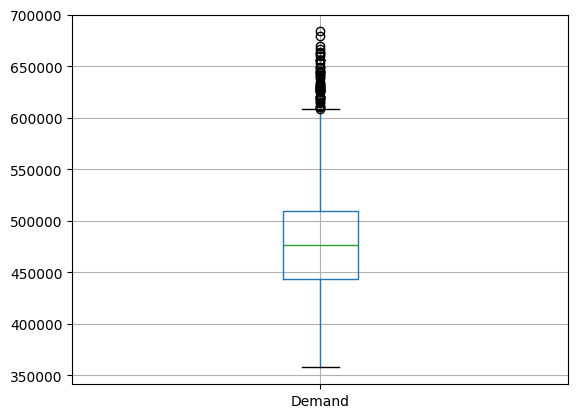

In [ ]:
usa_df.boxplot()
plt.show()

In [ ]:
usa_df.columns

Index(['Demand'], dtype='object')

In [ ]:
usa_df_reset = usa_df.reset_index()

fig = px.area(usa_df_reset, x="Time", y="Demand",
              title='Energy Demand in MWH')

fig.update_traces(hovertemplate="Time: %{x|%Y-%m-%d %H:%M:%S}<br>Demand: %{y}")
fig.update_xaxes(rangeslider_visible=True)
fig.show()


After taking a look at the data, and seeing that there were some clear signs of seasonality in it, we moved on to do exploratory analysis.

We looked for stationarity. For this we did an Augmented Dickey-Fuller (ADF) test.

For this, we decided upon the following Hypothesis to test:

Null Hypothesis (𝐻0): The time series is non-stationary.
Alternative Hypothesis (𝐻1): The time series is stationary.

In [ ]:
adfuller(usa_df['Demand'])

(-3.6026464300623156,
 0.005710634777025545,
 28,
 2553,
 {'1%': -3.43291399811863,
  '5%': -2.8626727710866504,
  '10%': -2.5673730161669357},
 48335.19004947489)

The results show that the ADF statistic is much smaller than all critical values, so we reject the null hypothesis. At the same time, they show a small p-value (0.0057), meaning that we reject the null hypothesis. With these results we thus assume stationarity. This means we do not need to apply transformations to the data before modeling it.

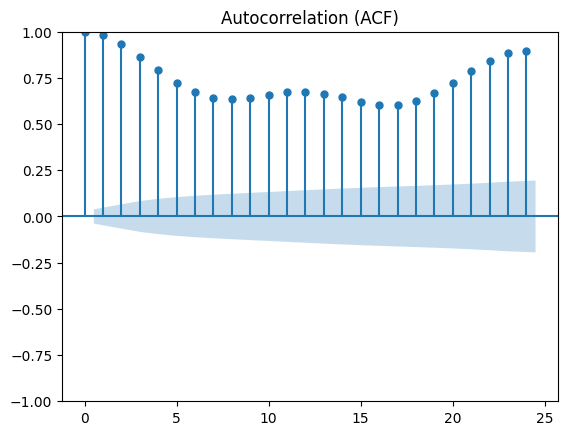

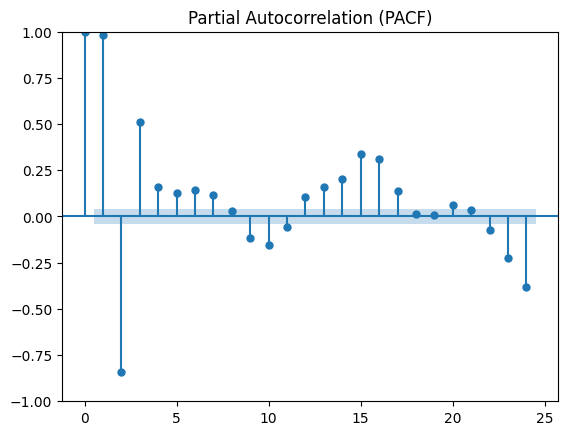

In [ ]:
#ACF
plot_acf(usa_df['Demand'], lags=24) #Lags are the cycles, set to 24 since the data is set to 24-hour intervals
plt.title("Autocorrelation (ACF)")
plt.show()

#PACF
plot_pacf(usa_df['Demand'], lags=24)
plt.title("Partial Autocorrelation (PACF)")
plt.show()

The ACF plot shows how the current value of "Demand" is correlated with past values (lags). The autocorrelation starts at lag 0, which is expected, and there are high positive correlations at multiple lags, indicating a strong dependence on previous values. The ACF values increase again at around lag 24, suggesting a 24-hour cycle in electricity demand.

The slow decay in the ACF tells us there is probably a trend or seasonality. The time series has a strong autocorrelation, meaning the past values strongly predict future values.

The PACF shows spikes in Lag 1 and Lag 2, meaning the current value of "Demand" is highly correlated with the last two time steps.
This suggests an AR(2) model could be appropriate.
Some Significant Spikes at Higher Lags (around Lag 5 and 16) might indicate a seasonal effect, or since the data follows a daily pattern, they could be because of peak times in demand (morning/evening peaks).

Normally, in a pure AR model, the PACF should cut off after a certain lag, but in this model we have some correlations at later lags, which might indicate a mixed ARMA process or it may suggest that we should do some differencing to remove residual trends.

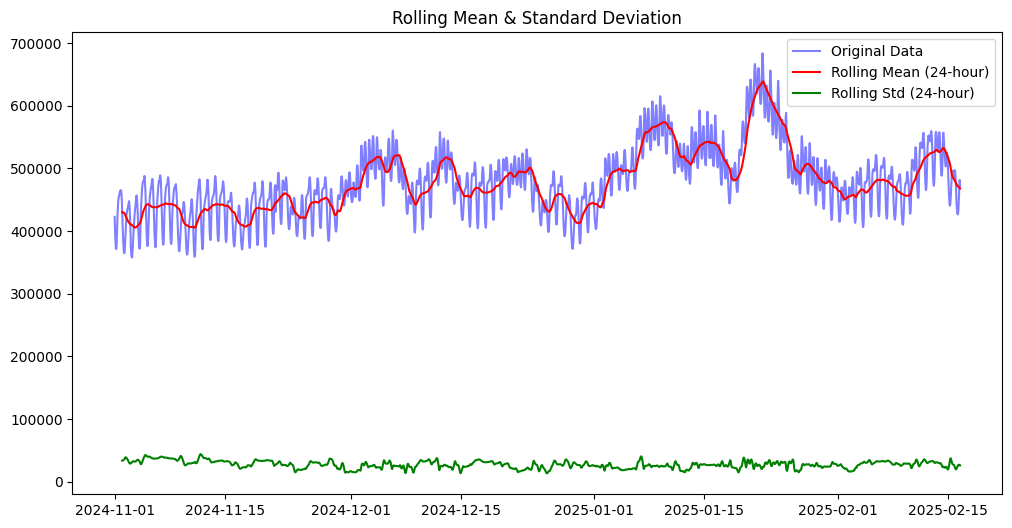

In [ ]:
rolling_mean = usa_df['Demand'].rolling(window=24).mean()
rolling_std = usa_df['Demand'].rolling(window=24).std()

plt.figure(figsize=(12,6))
plt.plot(usa_df['Demand'], label="Original Data", color='blue', alpha=0.5)
plt.plot(rolling_mean, label="Rolling Mean (24-hour)", color='red')
plt.plot(rolling_std, label="Rolling Std (24-hour)", color='green')
plt.legend()
plt.title("Rolling Mean & Standard Deviation")
plt.show()


This plot helps visually assess stationarity by examining whether the mean (red) and standard deviation (green) remain constant over time.

We can see that there are fluctuations in the rolling mean, suggesting that there is a trend and/or seasonality in electricity demand, or possible weekly/monthly cycles in demand.

The variance appears consistent, but if the rolling mean is not stationary, differencing may still be needed.

Demand fluctuates in a regular pattern, indicating seasonality (likely daily and weekly cycles).

The spikes could be due to weekday vs. weekend variations, holidays, or weather impacts.


In [ ]:
usa_df['Demand_diff'] = usa_df['Demand'].diff()

# Re-run ADF test with differencing
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(usa_df['Demand_diff'].dropna())
print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")


ADF Statistic: -7.339973519818026, p-value: 1.0715517312863915e-10


<Figure size 1200x600 with 0 Axes>

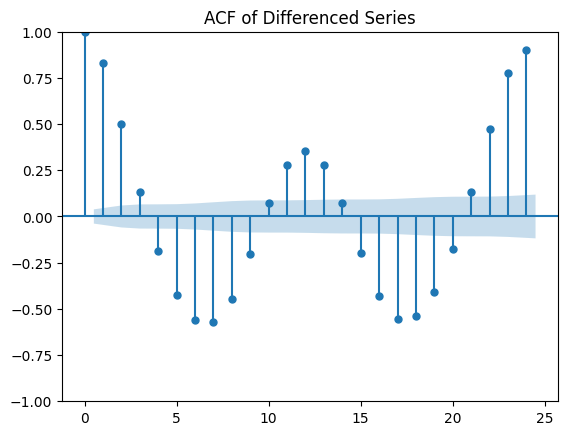

<Figure size 1200x600 with 0 Axes>

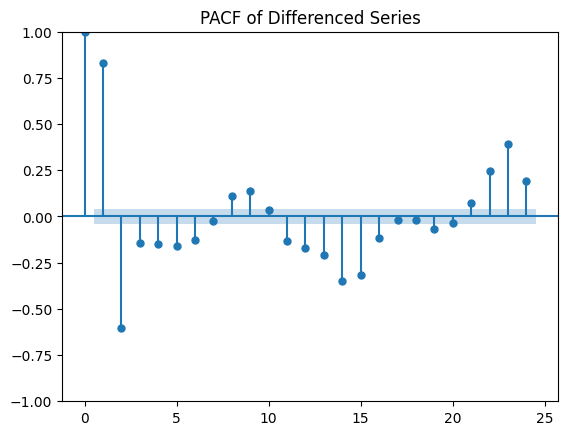

In [ ]:
plt.figure(figsize=(12,6))
plot_acf(usa_df['Demand_diff'].dropna(), lags=24)
plt.title("ACF of Differenced Series")
plt.show()

plt.figure(figsize=(12,6))
plot_pacf(usa_df['Demand_diff'].dropna(), lags=24)
plt.title("PACF of Differenced Series")
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Replace (p,q) with the values from ACF/PACF
model = ARIMA(usa_df['Demand'], order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                 Demand   No. Observations:                 2582
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -27469.439
Date:                Sun, 16 Feb 2025   AIC                          54948.878
Time:                        19:27:07   BIC                          54978.157
Sample:                             0   HQIC                         54959.490
                               - 2582                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7296      0.000   9858.158      0.000       1.729       1.730
ar.L2         -0.9976      0.000  -5087.733      0.000      -0.998      -0.997
ma.L1         -1.7156      0.001  -2615.781      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

<ipython-input-46-9520a530c770>:4: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



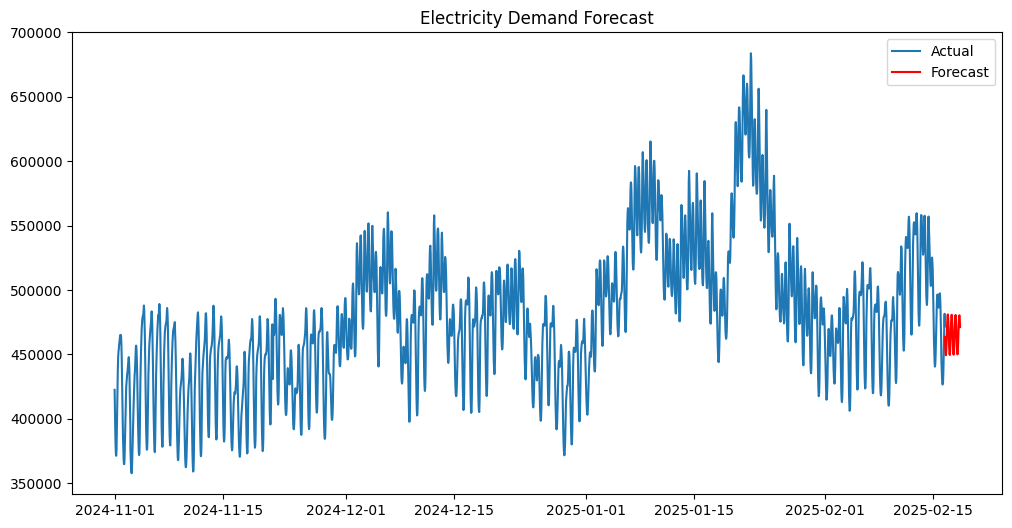

In [ ]:
forecast = model_fit.forecast(steps=48)  # Forecast next 48 time steps
plt.figure(figsize=(12,6))
plt.plot(usa_df.index, usa_df['Demand'], label="Actual")
plt.plot(pd.date_range(usa_df.index[-1], periods=48, freq='H'), forecast, label="Forecast", color="red")
plt.legend()
plt.title("Electricity Demand Forecast")
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA(p,d,q)(P,D,Q,s) model
sarima_model = SARIMAX(usa_df['Demand'],
                       order=(2,1,2),          # (p,d,q) from ACF/PACF
                       seasonal_order=(2,1,2,24))  # (P,D,Q,s) based on seasonality

# Fit the model
sarima_results = sarima_model.fit()

# Print summary
print(sarima_results.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                      
Dep. Variable:                             Demand   No. Observations:                 2582
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 24)   Log Likelihood              -24834.841
Date:                            Sun, 16 Feb 2025   AIC                          49687.682
Time:                                    19:32:00   BIC                          49740.301
Sample:                                         0   HQIC                         49706.763
                                           - 2582                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4425      0.029     49.325      0.000       1.385       1.500
ar.L2         -0.5996      0.014   

<ipython-input-48-ea13626ad9a2>:6: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



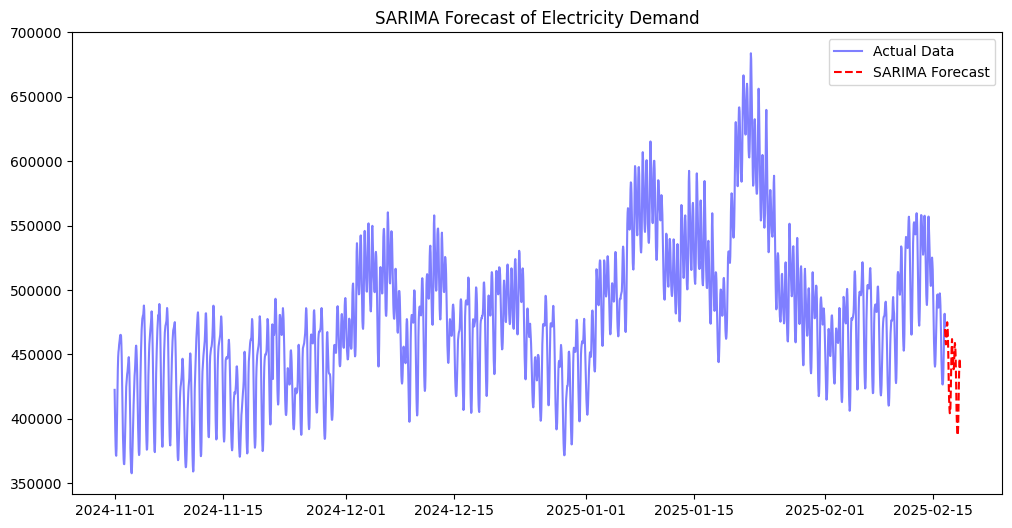

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Forecast next 48 hours
forecast_steps = 48
forecast_index = pd.date_range(usa_df.index[-1], periods=forecast_steps, freq='H')
forecast = sarima_results.forecast(steps=forecast_steps)

# Plot actual vs. forecast
plt.figure(figsize=(12,6))
plt.plot(usa_df.index, usa_df['Demand'], label="Actual Data", color="blue", alpha=0.5)
plt.plot(forecast_index, forecast, label="SARIMA Forecast", color="red", linestyle="dashed")
plt.legend()
plt.title("SARIMA Forecast of Electricity Demand")
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Compare last 48 actual values with forecast
actual_values = usa_df['Demand'][-48:]  # Last 48 actual points
predicted_values = forecast[:48]  # First 48 forecasted points


rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print(f"RMSE: {rmse:.2f}")


RMSE: 40837.66


In [ ]:
import pmdarima as pm

from pmdarima import auto_arima

# Run auto_arima to find the best SARIMA parameters
auto_sarima_model = auto_arima(usa_df['Demand'],
                               seasonal=True,  # Enable seasonality
                               m=24,           # Seasonal cycle = 24 hours
                               trace=True,     # Show progress
                               suppress_warnings=True,
                               stepwise=True)  # Stepwise optimization

# Print the best SARIMA order
print(auto_sarima_model.summary())



NameError: name 'usa_df' is not defined